In [ ]:
##################################### HELPER FUNCTIONS AND CONFIGURATIONS #########################################

import seaborn as sns # for data visualization
from matplotlib.collections import PathCollection
import os
import pprint
import random
import statistics
import scipy.stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [15, 10]
import json
import pandas as pd
import glob
%matplotlib inline

pp       =  pprint.PrettyPrinter(compact=True)

LOGFILES =  glob.glob('../logs/cleps-logs/test_data/*' )

#print(LOGFILES)
print(len(LOGFILES),"logs")

#=== line colors and styles

linestyles = {
    #=======scenarios========
    'empty'      :   'dotted',
    'canonical'  :   'dashed',
    'floorplan'  :  'dashdot',
    #=======algorithms=======
    #------exploration------- 
    'Atlas'      :    'solid',
    #----relay placement-----
    'Recovery'   :    'solid',
    'SelfHealing':    'solid',
    'Naive'      :    'solid',
}

linecolors = {
    #=======scenarios==========
    'empty'      :      'green',
    'canonical'  :       'blue',
    'floorplan'  :        'red',
    #=======algorithms=========
    #------exploration---------
    'Atlas'      :  'royalblue',
    #------relay placement-----
    'Recovery'   :     'purple',
    'SelfHealing':      'green',
    'Naive'      :     'orange',
     
   }

#=== helper functions

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m, h)

In [ ]:
#==================================================== GATHER DATA =============================================
data = {}
configs    = set()
for file in LOGFILES:
    FILENAME = file

    time       = []
    pdrs       = []
    avg_pdr    = []
    num_relays = []
    num_cells  = []
    run_data   = {}
    config     = None


    # gather
    with open(FILENAME,'r') as f:
        for line in f.readlines():
            jsonline = json.loads(line)
            if jsonline["type"] == "sim configuration":
                config = jsonline
                configs.add(str(config))
                if str(config) not in data.keys():
                    data[str(config)] = [] 
            if jsonline["type"]!='timeseries_kpi':
                continue

            # store
            time       += [jsonline["time"]]
            pdrs       += [[e[2] for e in jsonline["pdrProfile"]]]
            num_relays += [len([e[3] for e in jsonline["pdrProfile"] if e[3]])]
            num_cells  += [jsonline["numCells"]]
            
        run_data['time']            = time
        run_data['pdrs']            = pdrs
        run_data['num_relays']      = num_relays
        run_data['mappingProfile']  = num_cells

        data[str(config)] += [run_data]


In [ ]:
#===================================== MAPPING PROFILE=================================
plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
mapping_profiles = {}
plot_data = {}
for config,runs in data.items():
    mapping_profiles[str(config)] = [run['mappingProfile'] for run in runs]


for config,profiles in mapping_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        plot_data[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }

        
for config in configs:
    (fig,ax) = plt.subplots()
    lines    = {}
    for c,profile in plot_data.items():
        if c != config:
            continue
        x             = range(len(profile['mean']))
        y             = profile['mean']
        yerr          = profile['confidence_interval']
        yerrnonan = [y for y in yerr if not(math.isnan(y))]
        lines[c]      = ax.errorbar(x=x,y=y,yerr=0, ecolor='r')
    
    ax.grid(True, zorder=5)
    plt.xlabel('time (s)')
    plt.ylabel('number discovered cells')
    plt.legend()
    plt.show()

        
    
        
        
    

In [ ]:
#================================== AVERAGE PDR AND RELAY PLACEMENT ==================================================
import math

plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
avg_pdr_profiles = {}
relay_profiles = {}
plot_data_pdr = {}
plot_data_relay = {}



for config,runs in data.items():
    avg_pdr_profiles[str(config)] = []
    pdr_profiles  = [run['pdrs'] for run in runs]
    for profile in pdr_profiles:
        avg_pdr_profiles[str(config)] += [[(float(sum(p))/len(p)) for p in profile ]]



for config,profiles in avg_pdr_profiles.items():
    maxlen  = max(len(p) for p in profiles)
    ms      = []
    hs      = []
    for i in range(maxlen):
        l = []
        for p in profiles:
            try:
                l += [p[i]]
            except IndexError:
                pass
            (m,h) = mean_confidence_interval(l)
            ms += [m]
            hs += [h]
        plot_data_pdr[config] = {
            'mean':                ms,
            'confidence_interval': hs,
             }

    
for config in configs:
    (fig,ax) = plt.subplots()
    lines    = {}
    lines2 = {}
    for c,profile in plot_data_pdr.items():
        if c != config:
            continue
        x             = range(len(profile['mean']))
        y             = profile['mean']
        yerr          = profile['confidence_interval']
        lines[c]      = ax.errorbar(x=x,y=y,yerr=0, ecolor = 'b')

    
    ax.grid(True, zorder=5)
    plt.xlabel('Time (s)')
    plt.ylabel('PDR variance with time')

    plt.legend()
    alllines = lines
    plt.show()

In [ ]:
#================================== AVERAGE PDR AND RELAY PLACEMENT ==================================================
import math
import statistics
from statistics import mode

plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
avg_pdr_profiles = {}
relay_profiles = {}
plot_data_pdr = {}
plot_data_relay = {}

for config,runs in data.items():
    relay_profiles[config] = [run['num_relays'] for run in runs]
    for p in relay_profiles[config]:
        print()
        plt.plot(range(len(p)), p)

# for config,profiles in relay_profiles.items():
#     maxlen  = max(len(p) for p in profiles)
#     ms      = []
#     hs      = []
#     for i in range(maxlen):
#         l = []
#         for p in profiles:
#             try:
#                 l += [p[i]]
#             except IndexError:
#                 pass
#             #(m,h) = mean_confidence_interval(l)
#             if l:
#                 ms += [mode(l)]
#             #hs += [h]
#         plot_data_relay[config] = {
#             'mean':                ms,
#             'confidence_interval': hs,
#              }
    
# for config in configs:
#     (fig,ax) = plt.subplots()
#     lines2 = {}
#     for c,profile in plot_data_relay.items():
#         if c != config:
#             continue
#         x2             = range(len(profile['mean']))
#         y2             = profile['mean']
#         yerr2          = profile['confidence_interval']
#         ax2            = ax.twinx()
#         ax2.errorbar(x=x2,y=y2,yerr=0, color='g',ecolor='r')

    
#     ax2.grid(True, zorder=5)
#     plt.xlabel('Time (s)')
#     plt.ylabel('relay placement with time')

#     plt.legend()
#     alllines = lines
#     plt.show()

In [ ]:
#================================== PDR violin plots ==================================================
#-----------will group every 100 seconds together

import math

plt.rcParams['figure.figsize'] = [15, 10]
completion_times = []
pdr_collections = {}
relay_profiles = {}
plot_data_pdr = {}
plot_data_violin = {}



        
for config,runs in data.items():
    pdr_collections[str(config)] = []
    pdr_profiles  = [run['pdrs'] for run in runs]
    for profile in pdr_profiles:
        pdr_collections[str(config)] += profile
      
       
for config,collections in pdr_collections.items():
    plot_data_violin[config] = []

    for c in collections:
        
        plot_data_violin[config] += c
    n = 100
    plot_data_violin[config] = [plot_data_violin[config][i:i + n] for i in range(0, len(plot_data_violin[config]), n)]
    
for config in configs:
    (fig,ax) = plt.subplots()
    lines    = {}
    for c,profile in plot_data_violin.items():
        if c != config:
            continue
        x             = range(len(profile))
        y             = profile
        lines[c]      = ax.violinplot(y, vert=True, widths =1, showmeans=True, showextrema=False)
            
    ax.grid(True, zorder=5)
    plt.xlabel('Time (s)')
    plt.ylabel('PDR variance with time')
    plt.legend()
    alllines = lines
    plt.show()
    

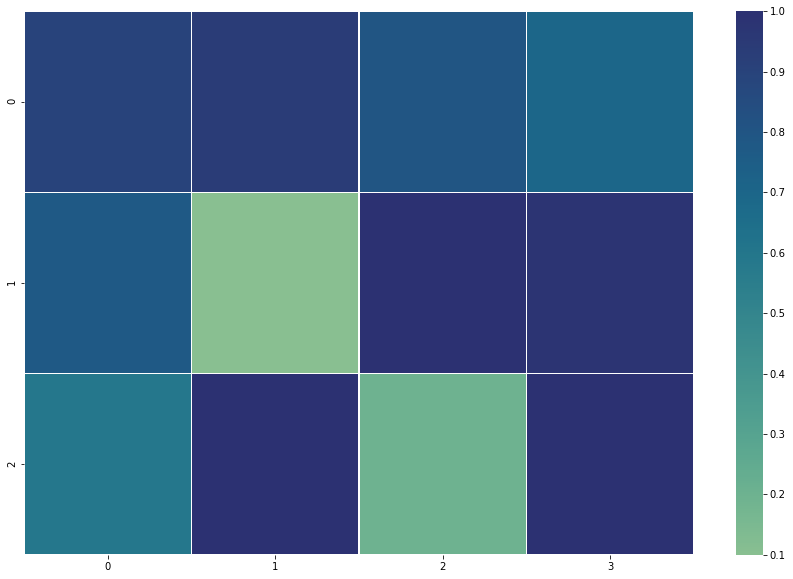

In [541]:
#======================================== HEATMAPS ============================================
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt



uniform_data = [[0.9,0.94,0.8,0.7],[0.78,0.1,1.0,0.98],[0.59,1.0,0.2,0.99]]

ax = sns.heatmap(uniform_data, linewidth=0.5,cmap="crest", center=0.5 )
plt.show()